In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# Load datasets
movies = pd.read_csv("movie_dataset.csv")
liked = pd.read_csv("liked_films.csv")

# Clean names for matching
movies['title_clean'] = movies['title'].str.lower().str.strip()
liked['name_clean'] = liked['Name'].str.lower().str.strip()


# Merge favorite status
movies['is_favorite'] = movies['title_clean'].isin(liked['name_clean'])

print(f"Matched favorites: {movies['is_favorite'].sum()} / {len(liked)}")

Matched favorites: 69 / 69


In [4]:
import ast

def parse_genres(genre_str):
    if pd.isna(genre_str) or genre_str == '':
        return []
    try:
        return ast.literal_eval(genre_str)
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)


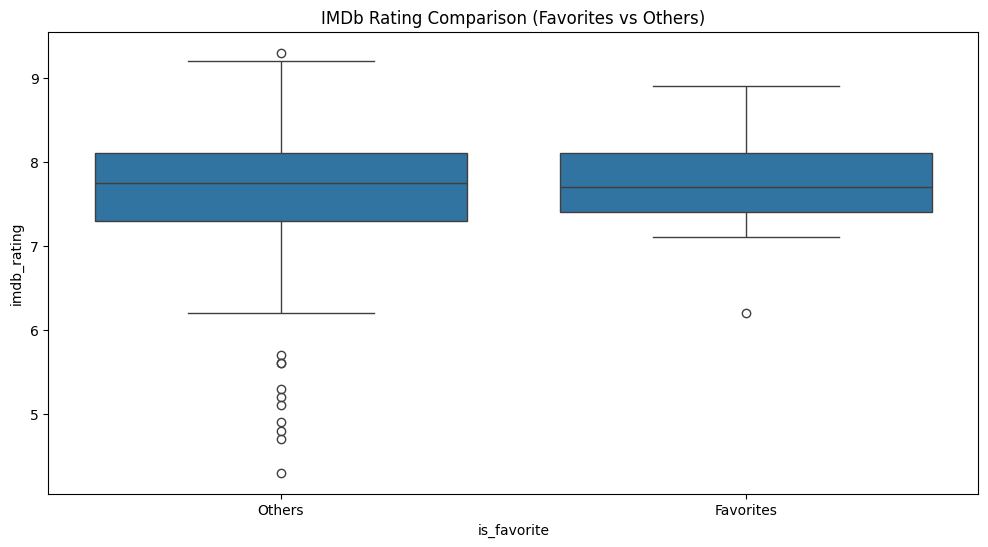

In [ ]:
#IMDb score comparison
plt.figure(figsize=(12,6))
sns.boxplot(x='is_favorite', y='imdb_rating', data=movies)
plt.xticks([0,1], ["Others","Favorites"])
plt.title("IMDb Rating Comparison (Favorites vs Others)")
plt.show()

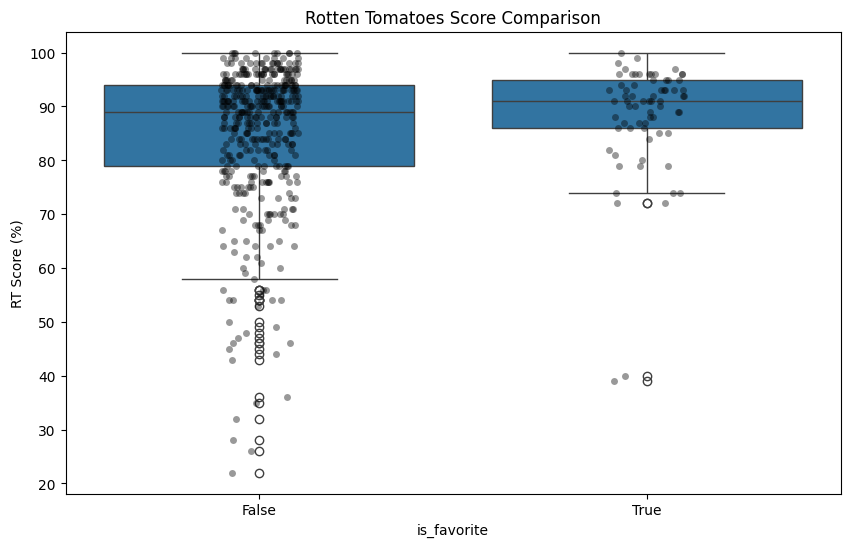

In [ ]:
#RT RATING CLEANING 
movies['rt_rating'] = (
    movies['rt_rating']
    .astype(str)
    .str.replace('%', '', regex=False)
)

movies['rt_rating'] = pd.to_numeric(movies['rt_rating'], errors='coerce')

# RT GRAPH
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies, x="is_favorite", y="rt_rating")
sns.stripplot(data=movies, x="is_favorite", y="rt_rating", color="black", alpha=0.4)

plt.title("Rotten Tomatoes Score Comparison")
plt.xlabel("is_favorite")
plt.ylabel("RT Score (%)")
plt.show()

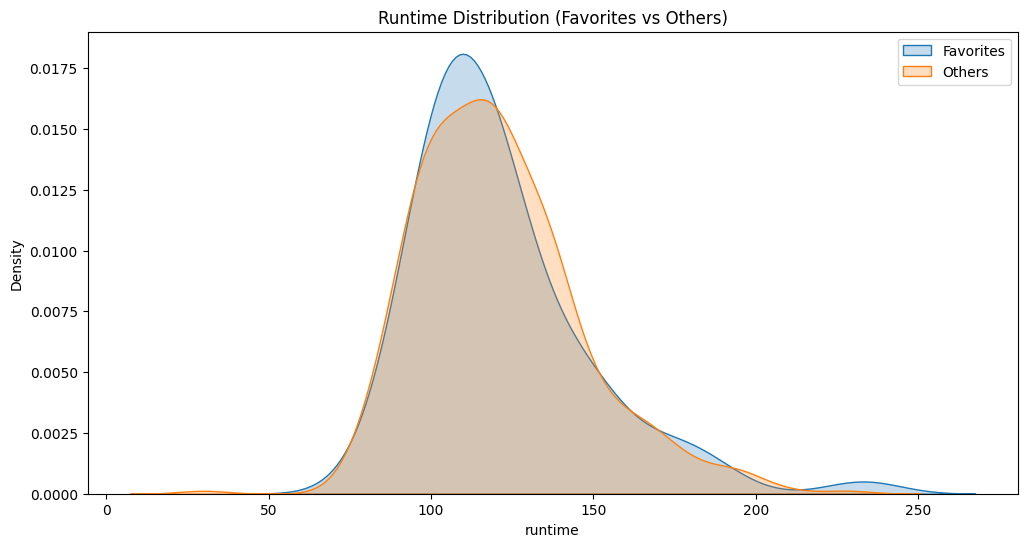

In [ ]:
# Runtime distribution
plt.figure(figsize=(12,6))
sns.kdeplot(movies[movies['is_favorite']==True]['runtime'], label="Favorites", fill=True)
sns.kdeplot(movies[movies['is_favorite']==False]['runtime'], label="Others", fill=True)
plt.legend()
plt.title("Runtime Distribution (Favorites vs Others)")
plt.show()

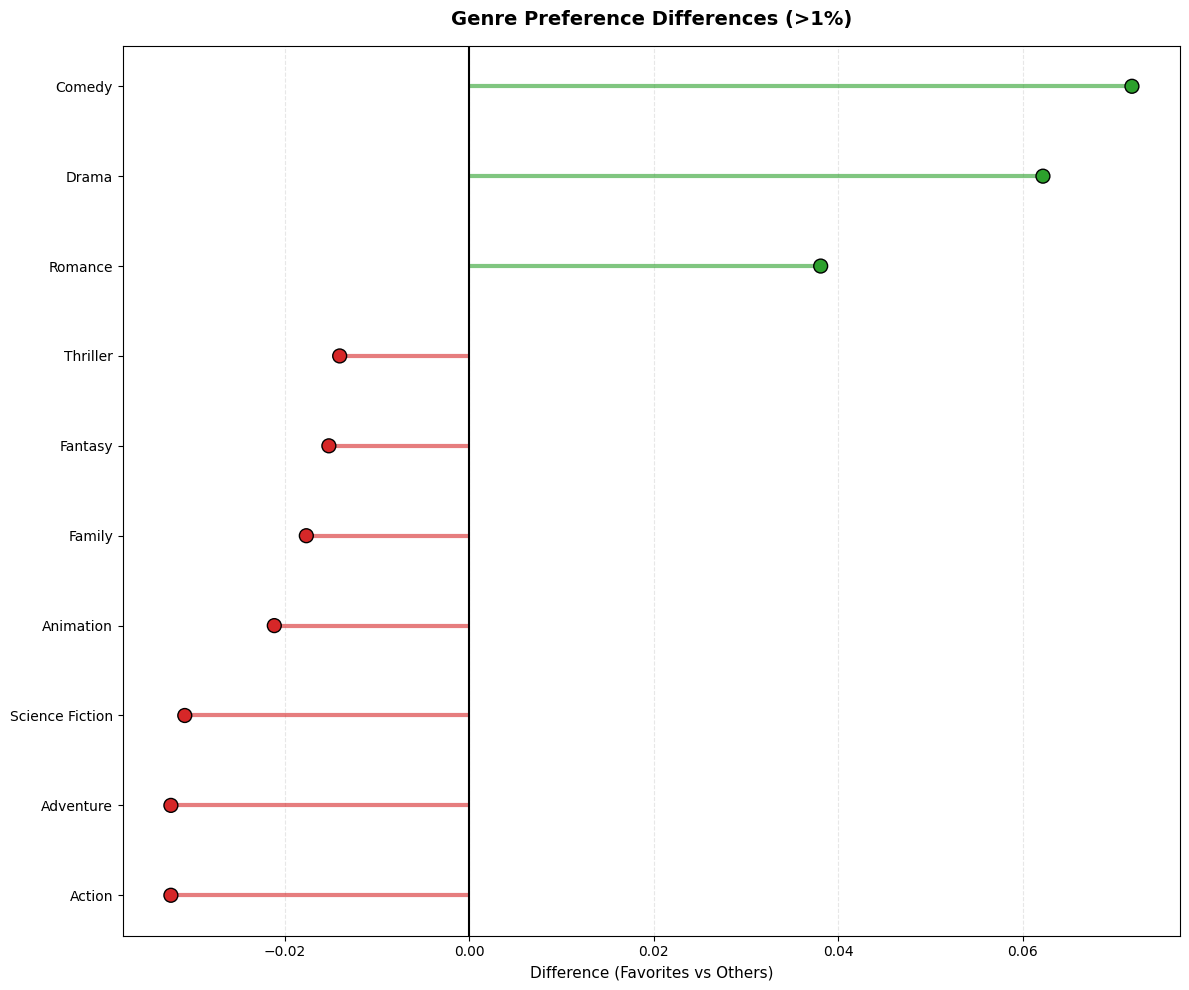

In [6]:
# Genre difference frequency
genre_df = movies.copy()

genre_exp = genre_df.explode('genre_list')

# clean genre names
genre_exp['genre_list'] = genre_exp['genre_list'].astype(str).str.strip()
genre_exp = genre_exp[genre_exp['genre_list'] != '']
genre_exp = genre_exp[genre_exp['genre_list'] != 'nan']

# calculate frequencies
fav_genres = genre_exp[genre_exp['is_favorite']==True]['genre_list'].value_counts(normalize=True)
other_genres = genre_exp[genre_exp['is_favorite']==False]['genre_list'].value_counts(normalize=True)
genre_compare = (fav_genres - other_genres).dropna().sort_values()

# Lollipop chart
plt.figure(figsize=(12,10))
significant = genre_compare[abs(genre_compare) > 0.01]

y_pos = range(len(significant))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in significant.values]

plt.hlines(y=y_pos, xmin=0, xmax=significant.values, color=colors, alpha=0.6, linewidth=3)
plt.scatter(significant.values, y_pos, color=colors, s=100, zorder=3, edgecolors='black', linewidth=1)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.yticks(y_pos, significant.index, fontsize=10)
plt.xlabel("Difference (Favorites vs Others)", fontsize=11)
plt.title("Genre Preference Differences (>1%)", fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
#Chi-Squared Test for Genre Association
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency

mlb = MultiLabelBinarizer()

genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=movies.index
)

movies_test = pd.concat([movies, genre_dummies], axis=1)
movies_test = movies_test.loc[:, ~movies_test.columns.duplicated()]

chi2_results = []

for g in genre_dummies.columns:
    x = movies_test[g].astype(int)   # ensure 1D numeric
    y = movies_test['is_favorite'].astype(int)

    table = pd.crosstab(x, y)

    if table.shape == (2, 2):
        chi2, p, dof, expected = chi2_contingency(table)
        chi2_results.append({
            "genre": g.replace("genre_", ""),
            "chi2": chi2,
            "p_value": p
        })

chi2_df = pd.DataFrame(chi2_results).sort_values("p_value")
chi2_df


,genre,chi2,p_value
3,Comedy,5.696490,0.016999
14,Science Fiction,3.255034,0.071204
6,Drama,3.002487,0.083137
1,Adventure,2.726686,0.098684
0,Action,2.726686,0.098684
13,Romance,2.368001,0.123846
2,Animation,1.943294,0.163311
10,Horror,1.673793,0.195751
7,Family,1.416970,0.233903
8,Fantasy,0.932760,0.334147


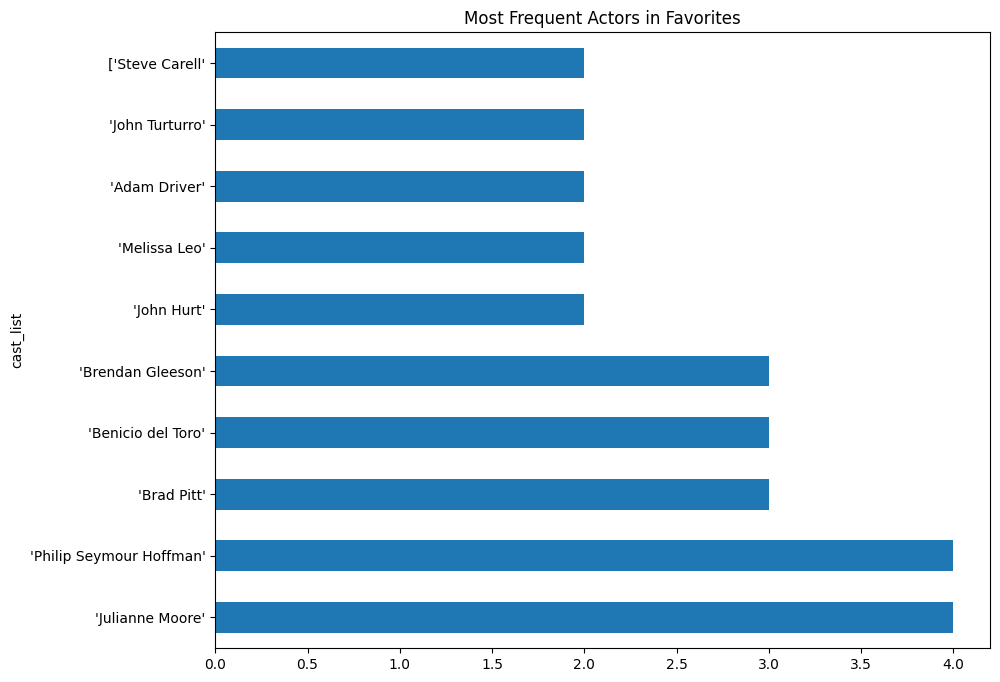

In [7]:
# Actor frequency (favorites)
actor_df = movies.copy()
actor_df['cast_list'] = actor_df['cast'].fillna("").str.split(',')

actor_exp = actor_df.explode('cast_list')
actor_exp['cast_list'] = actor_exp['cast_list'].str.strip()

top_actors = actor_exp[actor_exp['is_favorite']==True]['cast_list'].value_counts().head(10)

plt.figure(figsize=(10,8))
top_actors.plot(kind='barh')
plt.title("Most Frequent Actors in Favorites")
plt.show()

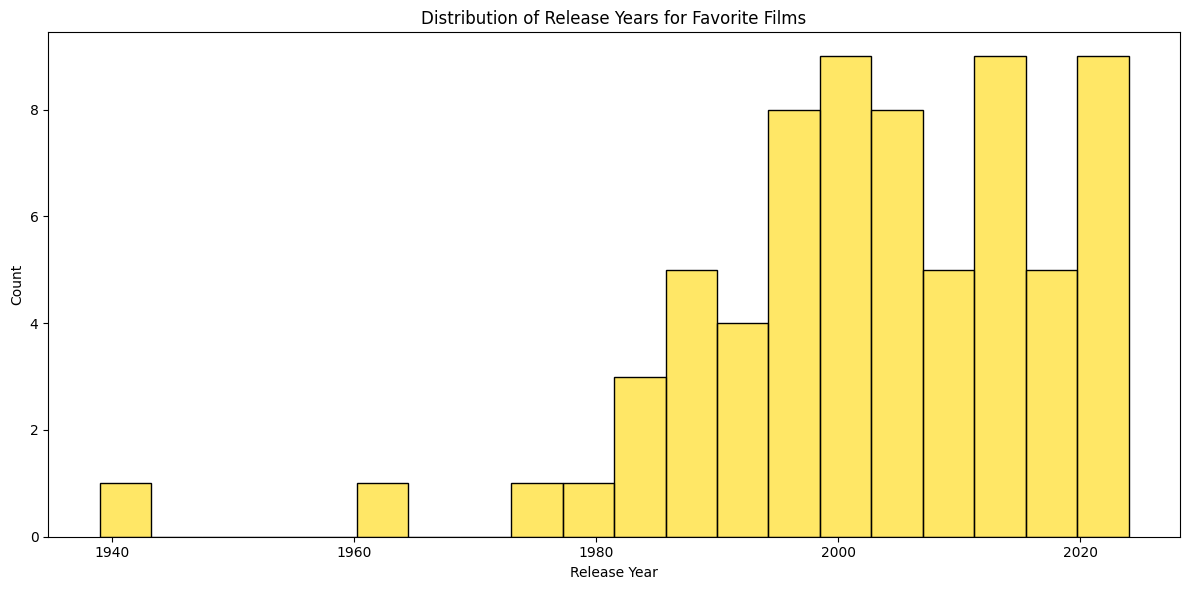

In [ ]:
plt.figure(figsize=(12,6))

sns.histplot(
    data=movies[movies['is_favorite'] == True],
    x="release_year",
    bins=20,
    color="gold",
    alpha=0.6
)

plt.title("Distribution of Release Years for Favorite Films")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

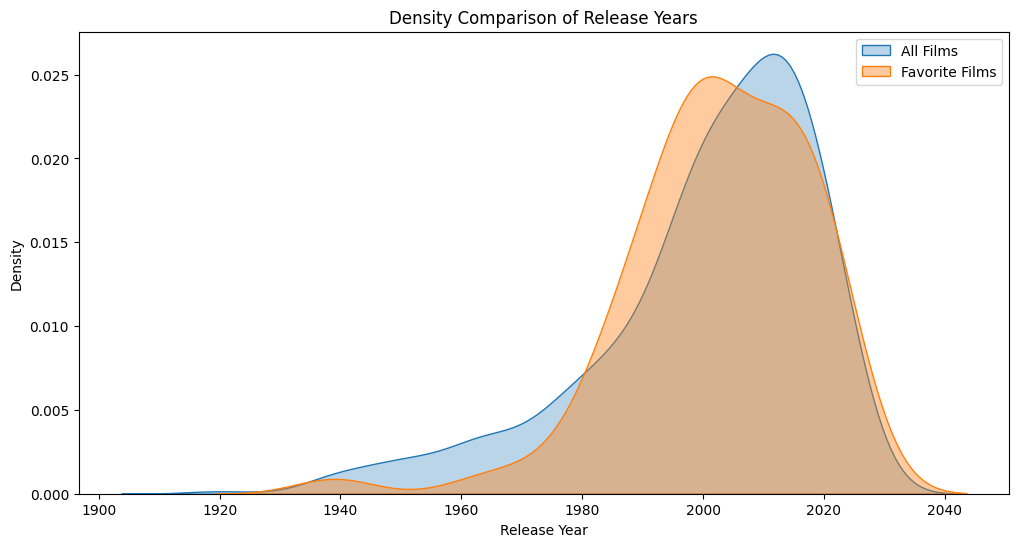

In [ ]:
plt.figure(figsize=(12,6))

sns.kdeplot(data=movies['release_year'], label="All Films", fill=True, alpha=0.3)
sns.kdeplot(
    data=movies[movies['is_favorite'] == True]['release_year'],
    label="Favorite Films",
    fill=True,
    alpha=0.4
)

plt.title("Density Comparison of Release Years")
plt.xlabel("Release Year")
plt.ylabel("Density")
plt.legend()
plt.show()